In [1]:
import logging
import numpy as np
import pandas as pd
import tensorflow as tf
import keras

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
log = logging.getLogger()

%config Completer.use_jedi = False # make autocompletion works in jupyter

tf.__version__

'2.4.1'

In [12]:
import argparse
import numpy as np
import pandas as pd
from pathlib import Path

args = argparse.Namespace()

args.n_splits = 5
args.n_jobs = -1
args.val_fraction = 0.1
args.epochs = 50
args.seed=101
args.reproducibility = True

args.run_baseline = True

args.raw_train = pd.read_csv('../data/train.csv.zip')
args.raw_test = pd.read_csv('../data/test.csv.zip')
args.train = args.raw_train.iloc[:, 1:].copy()
args.labels = args.raw_train['label'].copy()
args.test = args.raw_test.copy()
args.predictions_folder = Path('../predictions/best')
args.models_folder = Path('../models/best')

args.model_name = 'best.hdf5'

args.predictions_folder.mkdir(parents=True, exist_ok=True) 
args.models_folder.mkdir(parents=True, exist_ok=True) 
args.run_baseline = True
args.run_transfer = False
args.run_augment = True

In [13]:
import tensorflow as tf
import numpy as np


def reproducibility():
    if args.reproducibility:
        np.random.seed(args.seed)
        tf.random.set_seed(args.seed)

reproducibility()

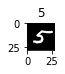

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def draw_digit(pixels_2d, label=None, size_inches=None):
    fig, ax = plt.subplots()
    if label is not None:
        ax.set_title(label)
    if size_inches:
        fig.set_size_inches(size_inches[0], size_inches[1])
    imgplot = ax.imshow(pixels_2d, cmap='gray')

random_row = random.randrange(0, args.raw_train.shape[0], 1)
label = args.raw_train.iloc[random_row, 0]
pixels_2d = args.raw_train.iloc[random_row, 1:].to_numpy().reshape(28, 28)
draw_digit(pixels_2d, label, (0.5, 0.5))

In [5]:
import sklearn.utils.multiclass

X_train_full = args.train.to_numpy().reshape(args.train.shape[0], 28, 28, 1) / 255.0
Y_train_full = pd.get_dummies(args.labels, prefix='label').to_numpy()
y_train_full = args.labels.to_numpy()
X_test = args.test.to_numpy().reshape(args.test.shape[0], 28, 28, 1) / 255.0

log.info('X_train_full.shape: %s', repr(X_train_full.shape))
# log.info('X[0][14][14]: %s', X[0][14][14])

log.info('Y_train_full.shape: %s', repr(Y_train_full.shape))
# log.info('y[0], %s', y[0])
log.info('Type of target Y_train_full: %s', repr(sklearn.utils.multiclass.type_of_target(Y_train_full)))

log.info('y_train_full.shape: %s', repr(y_train_full.shape))
# log.info('y_sparse: %s', repr(y_sparse))
# log.info('y_sparse[0]: %s', y_sparse[0])
log.info('Type of target y_train_full: %s', repr(sklearn.utils.multiclass.type_of_target(y_train_full)))

def plot_history(history):
    log.info("History keys: %s", history.history.keys())
    # Accuracy
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(history.history['accuracy'], label='Train')
    ax.plot(history.history['val_accuracy'], label='Test')
    ax.set_title('Model accuracy')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    ax.grid(True)
    ax.legend(['Train', 'Val'], loc='lower right')
    
    # Loss
    plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.grid()
    plt.show()
    
    
def csv_predictions(predictions, filename):
    log.debug('predictions.shape: %s', repr(predictions.shape))
    predictions_classes = np.argmax(predictions, axis=1)
    image_ids = np.arange(1, len(predictions_classes) + 1)
    submission = pd.DataFrame({'ImageId': image_ids, 'Label': predictions_classes})
    filepath = args.predictions_folder/filename
    submission.to_csv(filepath, index=False)
    log.info('Saved file: %s', filepath)


2021-05-10 17:24:20,301 : INFO : X_train_full.shape: (42000, 28, 28, 1)
2021-05-10 17:24:20,302 : INFO : Y_train_full.shape: (42000, 10)
2021-05-10 17:24:20,307 : INFO : Type of target Y_train_full: 'multilabel-indicator'
2021-05-10 17:24:20,307 : INFO : y_train_full.shape: (42000,)
2021-05-10 17:24:20,308 : INFO : Type of target y_train_full: 'multiclass'


### Baseline

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0

2021-05-10 17:38:18,844 : INFO : History keys: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping


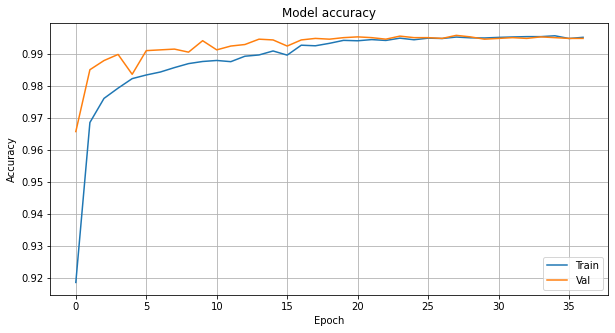

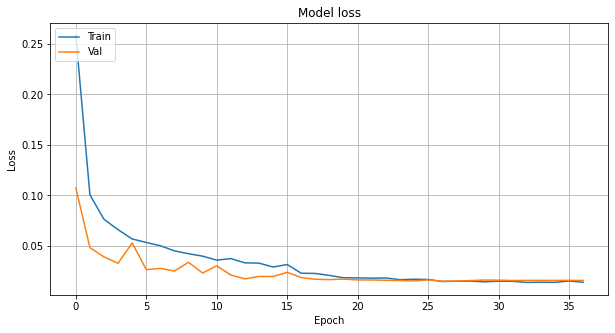

2021-05-10 17:38:23,375 : INFO : Saved file: ../predictions/best/baseline.csv


In [6]:
from tensorflow import keras
# 1-cycle lr
# data augmentation
# ensemble

def baseline_model():
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(28, 28, 1)))
    
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))
    model.add(keras.layers.Dropout(0.4))
    
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))
    model.add(keras.layers.Dropout(0.4))
    
    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.4))
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.BatchNormalization())
    
    model.add(keras.layers.Dense(10, activation='softmax'))
    
    model.compile(optimizer='nadam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    print(model.summary())
    
    monitor='val_loss'
    early_stopping = keras.callbacks.EarlyStopping(monitor=monitor, patience=10, mode='auto', restore_best_weights=True, verbose=1)
    reduce_lr_on_plateau = keras.callbacks.ReduceLROnPlateau(monitor=monitor, factor=0.1, patience=3, min_delta=1e-4, mode='auto', verbose=1)
    
    return model, [early_stopping, reduce_lr_on_plateau]

def baseline():
    reproducibility()
    model, callbacks = baseline_model()
    
    history = model.fit(X_train_full, y_train_full, validation_split=args.val_fraction, epochs=args.epochs, 
                        callbacks=callbacks, verbose=1)
    plot_history(history)
    
    predictions = model.predict(X_test)
    csv_predictions(predictions, 'baseline.csv')

if args.run_baseline:
    baseline()

| Model | Params  | Test score  | CV mean score |
|---|---|---|---|
| Baseline | No dropout, early_stopping='val_acc' | 0.99017 | 0.9924 |
| Baseline | Dropout=0.4, early_stopping='val_acc' | 0.99200 | 0.9931 |
| Baseline | Dropout=0.4, Batch normalization, early_stopping='val_acc'  | 0.99278 |  0.9943 |
| Baseline | Dropout=0.4, Batch normalization, early_stopping='val_loss'  | 0.99389 |  0.9948 |


##### Other results
| Model | Params  | Test score  | CV mean score |
|---|---|---|---|
| Baseline | Dropout=0.25 (after 2 first conv) | 0.99150 | 0.9929 |
| Baseline | Dropout=0.5 (after 2 first conv) | 0.99178 | 0.9924 |
| Baseline | Dropout=0.5  | 0.98867 | 0.9912 |
| Baseline | Dropout=0.3  | 0.99182 |  0.9936 |
| Baseline | Dropout=0.4 batch normalization before activation  | 0.99275 |  0.9929 |
| Baseline | Dropout=0.4 batch normalization he normal | 0.99250 |  0.9940 |

### Transfer learning

In [7]:
import matplotlib.pyplot as plt

def transfer_learning():
    batch_size = 32
    train_idx = len(X_train) - int(len(X_train) * args.val_fraction)
    val_idx = train_idx
#     train_idx = 50
#     val_idx = len(X_train) - train_idx 
    def preprocess(image, label):
        resized_image = tf.image.resize(image, [224, 224])
        rgb_image = tf.image.grayscale_to_rgb(resized_image)
        final_image = keras.applications.xception.preprocess_input(rgb_image)
        return final_image, label
    
    def dataset(features_labels):
        def debug_data(data):
            for d in data:
                print(d)
                fig, ax = plt.subplots()
                imgplot = ax.imshow(d[0][0])
                break
        data = tf.data.Dataset.from_tensor_slices(features_labels).shuffle(len(X_train)).map(preprocess).batch(batch_size).prefetch(1)
        return data
    
    def build_model():
        base_model = keras.applications.xception.Xception(weights="imagenet", include_top=False)
        avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
        output = keras.layers.Dense(10, activation='softmax')(avg)
        model = keras.Model(inputs=base_model.input, outputs=output)
        return base_model, model
    
    
    def train(base_model, model, train_data, val_data, train_base=False, epochs=5, lr=0.2):
        for l in base_model.layers:
            l.tranable = False
        optimizer = keras.optimizers.SGD(lr=lr, momentum=0.9, decay=0.01)
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        print(model.summary())
        history = model.fit(train_data, epochs=epochs, validation_data=val_data)
        plot_history(history)
    
    train_data = dataset((X_train[:train_idx], y_train[:train_idx]))
    val_data = dataset((X_train[val_idx:], y_train[val_idx:]))
    base_model, model = build_model()
    train(base_model, model, train_data, val_data)
    train(base_model, model, train_data, val_data, train_base=True, lr=0.01)

if args.run_transfer:
    transfer_learning()

### 1-cycle learning rate

### Data augmentation

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_52 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
batch_normalization_53 (Batc (None, 11, 11, 64)        256       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 5, 5, 64)        

2021-05-14 16:29:53,602 : INFO : History keys: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping


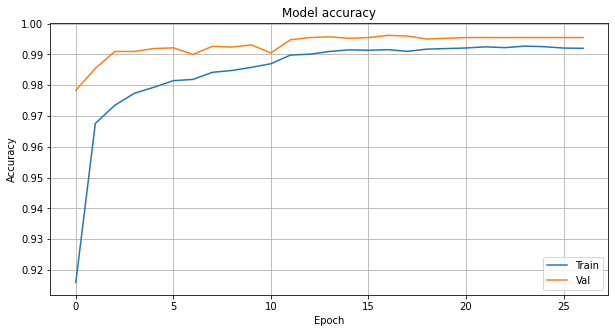

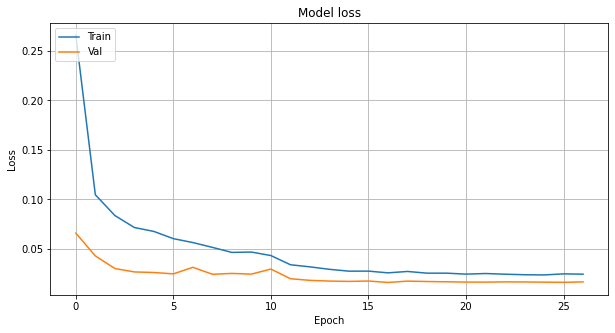

2021-05-14 16:29:58,259 : INFO : Saved file: ../predictions/best/augment.csv


In [23]:
from sklearn.model_selection import train_test_split

def data_augmentation():
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=args.val_fraction, 
                                                      random_state=args.seed)
    datagen = keras.preprocessing.image.ImageDataGenerator(
#         shear_range=0.2,
#         channel_shift_range=0.2,
        rotation_range=2,
        zoom_range=0.02,
        width_shift_range=0.02,
        height_shift_range=0.02)
#     val_modified_batch = datagen.flow(X_val, y_val, seed=args.seed).next()
#     draw_digit(val_modified_batch[0][0], val_modified_batch[1][0])
    
    datagen.fit(X_train, seed=args.seed)
    train_generator = datagen.flow(X_train, y_train, seed=args.seed)
#     i = 0
#     for d in train_generator:
#         i += d[0].shape[0]
#         if i > 200000:
#             print(i)
#     print(i)
    model, callbacks = baseline_model()
    history = model.fit(train_generator, epochs=args.epochs, validation_data=(X_val, y_val), callbacks=callbacks)
    plot_history(history)
    predictions = model.predict(X_test)
    csv_predictions(predictions, 'augment.csv')

if args.run_augment:
    data_augmentation()

| Model | Params  | Test score  | CV mean score | Val loss |
|---|---|---|---|---|
| Augment run 1 | Baseline model, Dropout=0.4, Batch normalization, early_stopping='val_loss', rotation_range=10, zoom_range=0.1, width_shift_range=0.1, height_shift_range=0.1  | 0.99421 | 0.9936 | 0.0188|
| Augment run 2 | Baseline model, Dropout=0.4, Batch normalization, early_stopping='val_loss', rotation_range=10, zoom_range=0.1, width_shift_range=0.1, height_shift_range=0.1  | 0.99453 | 0.9964 | 0.0135|
| Augment run 3 | Baseline model, Dropout=0.4, Batch normalization, early_stopping='val_loss', rotation_range=10, zoom_range=0.1, width_shift_range=0.1, height_shift_range=0.1  | 0.99435 | 0.9948 | 0.0151|
| Augment | Baseline model, Dropout=0.4, Batch normalization, early_stopping='val_loss', rotation_range=5, zoom_range=0.05, width_shift_range=0.05, height_shift_range=0.05  | 0.99503 | 0.9950 | 0.0147 |
| Augment | Baseline model, Dropout=0.4, Batch normalization, early_stopping='val_loss', rotation_range=2, zoom_range=0.02, width_shift_range=0.02, height_shift_range=0.02  | 0.99503 | 0.9962 | 0.0147 |
